In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display

# Métodos

## DMC(Distância Minima do Centroide)

In [60]:
def DMC(data, Nr, Ptrain):
    """
    Implementa o classificador de Distância Mínima do Centroide (DMC).

    Parâmetros:
    - data: Array numpy com os dados (features nas primeiras colunas, rótulo na última).
    - Nr: Número de execuções (rodadas) para avaliação do classificador.
    - Ptrain: Percentual de dados a serem usados para treinamento.

    Retorna:
    - STATS: Estatísticas de acurácia (média, min, max, mediana, desvio padrão).
    - TX_OK: Vetor com a taxa de acerto de cada uma das Nr execuções.
    - X: Dicionário com as amostras de treino por classe (da última execução).
    - m: Dicionário com os vetores de média (centroides) por classe (da última execução).
    """
    n_total_samples, p_plus_1 = data.shape
    num_features = p_plus_1 - 1
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    Ntrn = round(Ptrain * n_total_samples / 100)
    Ntst = n_total_samples - Ntrn

    # Encontra o número de classes. Supõe que as classes são rotuladas de 1 a K.
    unique_labels = np.unique(y_data)
    K = len(unique_labels)
    print(f'O problema tem {K} classes, {num_features} features. Método DMC.')

    TX_OK = np.zeros(Nr)

    for r in range(Nr):
        # Embaralhamento e divisão dos dados
        permutation = np.random.permutation(n_total_samples)
        train_indices = permutation[:Ntrn]
        test_indices = permutation[Ntrn:]

        X_train, y_train = X_data[train_indices], y_data[train_indices]
        X_test, y_test = X_data[test_indices], y_data[test_indices]

        # Dicionários para armazenar os resultados da última execução
        X, m = {}, {}
        
        # Treinamento: Cálculo dos centroides para cada classe
        classes_in_train = np.unique(y_train)
        for k in classes_in_train:
            X_k = X_train[y_train == k]
            X[k] = X_k
            m[k] = np.mean(X_k, axis=0)

        # Teste: Classificação das amostras
        # Matriz para armazenar as distâncias de cada amostra de teste para cada centroide
        distances = np.zeros((Ntst, len(classes_in_train)))

        for i, k in enumerate(classes_in_train):
            # Calcula a distância Euclidiana de todas as amostras de teste para o centroide da classe k
            distances[:, i] = np.linalg.norm(X_test - m[k], axis=1)
        
        # A classe predita é aquela com a menor distância (argmin)
        predicted_class_indices = np.argmin(distances, axis=1)
        predicted_labels = classes_in_train[predicted_class_indices]

        # Cálculo da acurácia para a rodada atual
        correct = np.sum(predicted_labels == y_test)
        TX_OK[r] = 100 * correct / Ntst

    # Consolidação dos resultados
    STATS = np.array([
        np.mean(TX_OK), np.min(TX_OK), np.max(TX_OK), np.median(TX_OK), np.std(TX_OK)
    ])

    return STATS, TX_OK, X, m

## 1-NN

In [61]:
def NN1(data, Nr, Ptrain):
    """
    Implementa o classificador do Vizinho Mais Próximo (1-NN).

    Parâmetros:
    - data: Array numpy com os dados (features nas primeiras colunas, rótulo na última).
    - Nr: Número de execuções (rodadas) para avaliação do classificador.
    - Ptrain: Percentual de dados a serem usados para treinamento.

    Retorna:
    - STATS: Estatísticas de acurácia (média, min, max, mediana, desvio padrão).
    - TX_OK: Vetor com a taxa de acerto de cada uma das Nr execuções.
    - X_train_last_run: Amostras de treino da última execução.
    - y_train_last_run: Rótulos de treino da última execução.
    """
    n_total_samples, p_plus_1 = data.shape
    num_features = p_plus_1 - 1
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    Ntrn = round(Ptrain * n_total_samples / 100)
    Ntst = n_total_samples - Ntrn

    K = len(np.unique(y_data))
    print(f'O problema tem {K} classes, {num_features} features. Método 1-NN.')

    TX_OK = np.zeros(Nr)

    # Variáveis para guardar os dados da última execução
    X_train_last_run, y_train_last_run = None, None

    for r in range(Nr):
        permutation = np.random.permutation(n_total_samples)
        train_indices = permutation[:Ntrn]
        test_indices = permutation[Ntrn:]

        X_train, y_train = X_data[train_indices], y_data[train_indices]
        X_test, y_test = X_data[test_indices], y_data[test_indices]
        
        if r == Nr - 1:
            X_train_last_run = X_train
            y_train_last_run = y_train

        # Treinamento: Apenas memoriza os dados (não há cálculo de modelo)

        # Teste: Classificação das amostras
        predicted_labels = np.zeros(Ntst, dtype=int)
        
        for i in range(Ntst):
            # Calcula a distância da amostra de teste atual para TODAS as amostras de treino
            distances = np.linalg.norm(X_train - X_test[i, :], axis=1)
            
            # Encontra o índice da amostra de treino com a menor distância
            nearest_neighbor_index = np.argmin(distances)
            
            # Atribui o rótulo do vizinho mais próximo
            predicted_labels[i] = y_train[nearest_neighbor_index]

        correct = np.sum(predicted_labels == y_test)
        TX_OK[r] = 100 * correct / Ntst

    # Consolidação dos resultados
    STATS = np.array([
        np.mean(TX_OK), np.min(TX_OK), np.max(TX_OK), np.median(TX_OK), np.std(TX_OK)
    ])

    return STATS, TX_OK, X_train_last_run, y_train_last_run

## Máxima correlação

In [62]:
def MaxCorr(data, Nr, Ptrain):
    """
    Implementa o Classificador de Máxima Correlação.

    Parâmetros:
    - data: Array numpy com os dados (features nas primeiras colunas, rótulo na última).
    - Nr: Número de execuções (rodadas) para avaliação do classificador.
    - Ptrain: Percentual de dados a serem usados para treinamento.

    Retorna:
    - STATS: Estatísticas de acurácia (média, min, max, mediana, desvio padrão).
    - TX_OK: Vetor com a taxa de acerto de cada uma das Nr execuções.
    - X: Dicionário com as amostras de treino por classe (da última execução).
    - m: Dicionário com os vetores de média (centroides) por classe (da última execução).
    """
    n_total_samples, p_plus_1 = data.shape
    num_features = p_plus_1 - 1
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    Ntrn = round(Ptrain * n_total_samples / 100)
    Ntst = n_total_samples - Ntrn

    unique_labels = np.unique(y_data)
    K = len(unique_labels)
    print(f'O problema tem {K} classes, {num_features} features. Método Máxima Correlação.')

    TX_OK = np.zeros(Nr)

    for r in range(Nr):
        permutation = np.random.permutation(n_total_samples)
        train_indices = permutation[:Ntrn]
        test_indices = permutation[Ntrn:]

        X_train, y_train = X_data[train_indices], y_data[train_indices]
        X_test, y_test = X_data[test_indices], y_data[test_indices]

        X, m, m_norm = {}, {}, {}
        
        # Treinamento: Cálculo dos centroides e sua normalização
        classes_in_train = np.unique(y_train)
        for k in classes_in_train:
            X_k = X_train[y_train == k]
            X[k] = X_k
            
            # Calcula o centroide
            centroid = np.mean(X_k, axis=0)
            m[k] = centroid
            
            # Normaliza o centroide (adiciona epsilon para evitar divisão por zero)
            norm_centroid = np.linalg.norm(centroid)
            m_norm[k] = centroid / (norm_centroid + 1e-9)

        # Teste: Classificação das amostras
        
        # Normaliza todas as amostras de teste (adiciona epsilon para evitar divisão por zero)
        # O keepdims=True garante que a divisão seja feita linha por linha corretamente
        norms_X_test = np.linalg.norm(X_test, axis=1, keepdims=True)
        X_test_norm = X_test / (norms_X_test + 1e-9)
        
        # Matriz para armazenar as correlações (produtos escalares)
        correlations = np.zeros((Ntst, len(classes_in_train)))

        for i, k in enumerate(classes_in_train):
            # Calcula o produto escalar entre todos os vetores de teste normalizados e o centroide normalizado da classe k
            correlations[:, i] = X_test_norm @ m_norm[k]
        
        # A classe predita é aquela com a maior correlação (argmax)
        predicted_class_indices = np.argmax(correlations, axis=1)
        predicted_labels = classes_in_train[predicted_class_indices]

        correct = np.sum(predicted_labels == y_test)
        TX_OK[r] = 100 * correct / Ntst

    # Consolidação dos resultados
    STATS = np.array([
        np.mean(TX_OK), np.min(TX_OK), np.max(TX_OK), np.median(TX_OK), np.std(TX_OK)
    ])

    return STATS, TX_OK, X, m

## Quadrático

In [63]:
def quadratico(data, Nr, Ptrain):
    """
    Implementa o classificador de Análise Discriminante Quadrática (QDA).

    Parâmetros:
    - data: Array numpy com os dados (features na primeiras colunas, rótulo na última).
    - Nr: Número de execuções (rodadas) para avaliação do classificador.
    - Ptrain: Percentual de dados a serem usados para treinamento.

    Retorna:
    - STATS: Estatísticas de acurácia (média, min, max, mediana, desvio padrão).
    - TX_OK: Vetor com a taxa de acerto de cada uma das Nr execuções.
    - X: Dicionário com as amostras de treino por classe (da última execução).
    - m: Dicionário com os vetores de média por classe (da última execução).
    - S: Dicionário com as matrizes de covariância por classe (da última execução).
    - posto: Dicionário com os ranks das matrizes de covariância (da última execução).
    """
    n_total_samples, p_plus_1 = data.shape
    num_features = p_plus_1 - 1
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    Ntrn = round(Ptrain * n_total_samples / 100)
    Ntst = n_total_samples - Ntrn

    K = np.max(y_data)
    print(f'O problema tem {K} classes, {num_features} features. Método QDA.')

    TX_OK = np.zeros(Nr)

    for r in range(Nr):
        permutation = np.random.permutation(n_total_samples)
        train_indices = permutation[:Ntrn]
        test_indices = permutation[Ntrn:]

        X_train, y_train = X_data[train_indices], y_data[train_indices]
        X_test, y_test = X_data[test_indices], y_data[test_indices]

        X, m, S, posto = {}, {}, {}, {}
        inv_covs, log_dets, log_priors = {}, {}, {}

        unique_classes_in_train = np.unique(y_train)

        # Treinamento: Cálculo dos parâmetros para cada classe
        for k in unique_classes_in_train:
            X_k = X_train[y_train == k]
            X[k] = X_k
            
            m_k = np.mean(X_k, axis=0)
            S_k = np.cov(X_k, rowvar=False)

            m[k] = m_k
            S[k] = S_k
            posto[k] = np.linalg.matrix_rank(S_k)

            iS_k = np.linalg.pinv(S_k)
            sign, log_det_S_k = np.linalg.slogdet(S_k)
            log_det_S_k = log_det_S_k if sign > 0 else -np.inf

            prior_k = X_k.shape[0] / Ntrn
            inv_covs[k] = iS_k
            log_dets[k] = log_det_S_k
            log_priors[k] = np.log(prior_k)

        # Teste: Classificação das amostras
        discriminant_scores = np.zeros((Ntst, len(unique_classes_in_train)))

        for i, k in enumerate(unique_classes_in_train):
            diff = X_test - m[k]
            mahalanobis_dist = np.sum((diff @ inv_covs[k]) * diff, axis=1)
            discriminant_scores[:, i] = mahalanobis_dist + log_dets[k] - 2 * log_priors[k]

        predicted_class_indices = np.argmin(discriminant_scores, axis=1)
        predicted_labels = unique_classes_in_train[predicted_class_indices]

        correct = np.sum(predicted_labels == y_test)
        TX_OK[r] = 100 * correct / Ntst

    # Consolidação dos resultados
    STATS = np.array([
        np.mean(TX_OK), np.min(TX_OK), np.max(TX_OK), np.median(TX_OK), np.std(TX_OK)
    ])

    return STATS, TX_OK, X, m, S, posto

## Variante 1

In [64]:
def variante1(data, Nr, Ptrain, reg_lambda):
    """
    Implementa o classificador QDA supostamente com regularização de Tikhonov.

    Parâmetros:
    - data: Array numpy com os dados.
    - Nr: Número de execuções.
    - Ptrain: Percentual de dados para treinamento.
    - alpha: Parâmetro de regularização (não utilizado no código).

    Retorna:
    - Mesmos outputs da função `quadratico`.
    """
    n_total_samples, p_plus_1 = data.shape
    num_features = p_plus_1 - 1
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    Ntrn = round(Ptrain * n_total_samples / 100)
    Ntst = n_total_samples - Ntrn

    K = np.max(y_data)
    print(f'O problema tem {K} classes, {num_features} features. Lambda={reg_lambda}')

    TX_OK = np.zeros(Nr)

    for r in range(Nr):
        permutation = np.random.permutation(n_total_samples)
        train_indices, test_indices = permutation[:Ntrn], permutation[Ntrn:]

        X_train, y_train = X_data[train_indices], y_data[train_indices]
        X_test, y_test = X_data[test_indices], y_data[test_indices]

        X, m, S, posto = {}, {}, {}, {}
        inv_covs, log_dets, log_priors = {}, {}, {}

        unique_classes_in_train = np.unique(y_train)

        # Treinamento
        for k in unique_classes_in_train:
            X_k = X_train[y_train == k]
            X[k] = X_k

            m_k = np.mean(X_k, axis=0)
            S_k = np.cov(X_k, rowvar=False) + np.eye(num_features) * reg_lambda 

            m[k] = m_k
            S[k] = S_k  # Regularização de Tikhonov 
            posto[k] = np.linalg.matrix_rank(S_k)

            iS_k = np.linalg.pinv(S_k)
            sign, log_det_S_k = np.linalg.slogdet(S_k)
            log_det_S_k = log_det_S_k if sign > 0 else -np.inf
            
            prior_k = X_k.shape[0] / Ntrn
            inv_covs[k] = iS_k
            log_dets[k] = log_det_S_k
            log_priors[k] = np.log(prior_k)

        # Teste
        discriminant_scores = np.zeros((Ntst, len(unique_classes_in_train)))

        for i, k in enumerate(unique_classes_in_train):
            diff = X_test - m[k]
            mahalanobis_dist = np.sum((diff @ inv_covs[k]) * diff, axis=1)
            discriminant_scores[:, i] = mahalanobis_dist + log_dets[k] - 2 * log_priors[k]

        predicted_class_indices = np.argmin(discriminant_scores, axis=1)
        predicted_labels = unique_classes_in_train[predicted_class_indices]

        correct = np.sum(predicted_labels == y_test)
        TX_OK[r] = 100 * correct / Ntst

    # Consolidação
    STATS = np.array([
        np.mean(TX_OK), np.min(TX_OK), np.max(TX_OK), np.median(TX_OK), np.std(TX_OK)
    ])

    return STATS, TX_OK, X, m, S, posto

## Variante 2

In [65]:
def variante2(data, Nr, Ptrain):
    """
    Implementa o classificador QDA com matriz de covariância POOLED.
    Utiliza uma única matriz de covariância (pooled) para todas as classes.

    Retorna:
    - S: A matriz de covariância POOLED única (da última execução).
    - posto: O rank da matriz POOLED (da última execução).
    - Outros outputs são análogos à função `quadratico`.
    """
    n_total_samples, p_plus_1 = data.shape
    num_features = p_plus_1 - 1
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    Ntrn = round(Ptrain * n_total_samples / 100)
    Ntst = n_total_samples - Ntrn

    K = np.max(y_data)
    print(f'O problema tem {K} classes, {num_features} features. Método LDA (Pooled Cov).')

    TX_OK = np.zeros(Nr)
    X_final, m_final, S_final, posto_final = {}, {}, None, None

    for r in range(Nr):
        permutation = np.random.permutation(n_total_samples)
        train_indices, test_indices = permutation[:Ntrn], permutation[Ntrn:]
        X_train, y_train = X_data[train_indices], y_data[train_indices]
        X_test, y_test = X_data[test_indices], y_data[test_indices]

        m, log_priors, priors = {}, {}, {}
        unique_classes_in_train = np.unique(y_train)

        current_X = {}
        individual_S = {}

        # Passo A: Calcular médias e covariâncias individuais
        for k in unique_classes_in_train:
            X_k = X_train[y_train == k]
            current_X[k] = X_k
            m[k] = np.mean(X_k, axis=0)
            individual_S[k] = np.cov(X_k, rowvar=False)
            priors[k] = X_k.shape[0] / Ntrn
            log_priors[k] = np.log(priors[k])

        # Passo B: Calcular a matriz de covariância única (pooled)
        C_pool = np.zeros((num_features, num_features))
        for k in unique_classes_in_train:
            prior_k = priors[k]
            C_pool += prior_k * individual_S[k]

        inv_C_pool = np.linalg.pinv(C_pool)

        if r == Nr - 1:
            X_final, m_final, S_final, posto_final = current_X, m, C_pool, np.linalg.matrix_rank(C_pool)

        # Teste
        dist_scores = np.zeros((Ntst, len(unique_classes_in_train)))
        for i, k in enumerate(unique_classes_in_train):
            diff = X_test - m[k]
            mahalanobis_dist = np.sum((diff @ inv_C_pool) * diff, axis=1)
            dist_scores[:, i] = mahalanobis_dist - 2 * log_priors[k]

        predicted_class_indices = np.argmin(dist_scores, axis=1)
        predicted_labels = unique_classes_in_train[predicted_class_indices]

        correct = np.sum(predicted_labels == y_test)
        TX_OK[r] = 100 * correct / Ntst

    STATS = np.array([np.mean(TX_OK), np.min(TX_OK), np.max(TX_OK), np.median(TX_OK), np.std(TX_OK)])
    return STATS, TX_OK, X_final, m_final, S_final, posto_final


## Variante 3

In [66]:
def variante3(data, Nr, Ptrain, lambda_reg):
    """
    Implementa o classificador com Regularização de Friedman (RDA).
    Cria uma matriz de covariância para cada classe interpolando entre a matriz
    individual da classe e a matriz pooled geral.

    Parâmetros:
    - lambda_reg: Parâmetro de regularização (0 <= lambda <= 1).
    - Outros parâmetros e retornos são análogos às funções anteriores.
    """
    if not (0 <= lambda_reg <= 1):
        raise ValueError("O parâmetro lambda_reg deve estar entre 0 e 1.")

    n_total_samples, p_plus_1 = data.shape
    num_features = p_plus_1 - 1
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    Ntrn = round(Ptrain * n_total_samples / 100)
    Ntst = n_total_samples - Ntrn

    K = np.max(y_data)
    print(f'O problema tem {K} classes, {num_features} features. Lambda={lambda_reg}')

    TX_OK = np.zeros(Nr)
    X_final, m_final, S_final, posto_final = {}, {}, {}, {}

    for r in range(Nr):
        permutation = np.random.permutation(n_total_samples)
        train_indices, test_indices = permutation[:Ntrn], permutation[Ntrn:]
        X_train, y_train = X_data[train_indices], y_data[train_indices]
        X_test, y_test = X_data[test_indices], y_data[test_indices]

        m, log_priors = {}, {}
        inv_covs, log_dets = {}, {}
        current_X, current_S_reg, current_posto_reg = {}, {}, {}
        unique_classes_in_train = np.unique(y_train)

        # Treinamento (Método de Friedman)
        scatter_matrices = {}
        num_samples_per_class = {}
        for k in unique_classes_in_train:
            X_k = X_train[y_train == k]
            current_X[k] = X_k
            N_k = X_k.shape[0]

            m[k] = np.mean(X_k, axis=0)
            log_priors[k] = np.log(N_k / Ntrn) if N_k > 0 else -np.inf
            num_samples_per_class[k] = N_k

            if N_k > 1:
                scatter_matrices[k] = (N_k - 1) * np.cov(X_k, rowvar=False)
            else:
                scatter_matrices[k] = np.zeros((num_features, num_features))

        scatter_S_pool = Ntrn * np.cov(X_train, rowvar=False)

        for k in unique_classes_in_train:
            N_k = num_samples_per_class.get(k, 0)
            S_k = scatter_matrices.get(k, np.zeros((num_features, num_features)))

            numerator = (1 - lambda_reg) * S_k + lambda_reg * scatter_S_pool
            denominator = (1 - lambda_reg) * N_k + lambda_reg * Ntrn

            if denominator <= 0:
                C_lambda_k = np.zeros((num_features, num_features))
            else:
                C_lambda_k = numerator / denominator

            current_S_reg[k] = C_lambda_k
            current_posto_reg[k] = np.linalg.matrix_rank(C_lambda_k)
            inv_covs[k] = np.linalg.pinv(C_lambda_k)
            sign, log_det = np.linalg.slogdet(C_lambda_k)
            log_dets[k] = log_det if sign > 0 else -np.inf

        if r == Nr - 1:
            X_final, m_final, S_final, posto_final = current_X, m, current_S_reg, current_posto_reg

        # Teste
        discriminant_scores = np.zeros((Ntst, len(unique_classes_in_train)))
        for i, k in enumerate(unique_classes_in_train):
            if k in m:
                diff = X_test - m[k]
                mahalanobis_dist = np.sum((diff @ inv_covs[k]) * diff, axis=1)
                discriminant_scores[:, i] = mahalanobis_dist + log_dets[k] - 2 * log_priors[k]
            else:
                discriminant_scores[:, i] = np.inf

        predicted_class_indices = np.argmin(discriminant_scores, axis=1)
        predicted_labels = unique_classes_in_train[predicted_class_indices]
        correct = np.sum(predicted_labels == y_test)
        TX_OK[r] = 100 * correct / Ntst

    STATS = np.array([np.mean(TX_OK), np.min(TX_OK), np.max(TX_OK), np.median(TX_OK), np.std(TX_OK)])
    return STATS, TX_OK, X_final, m_final, S_final, posto_final


## Variante 4

In [67]:
def variante4(data, Nr, Ptrain):
    """
    Implementa o classificador Naive Bayes Gaussiano.
    Assume que os atributos são condicionalmente independentes, forçando a
    matriz de covariância de cada classe a ser diagonal.

    Retorna:
    - S: Dicionário com as matrizes de covariância DIAGONAIS (da última execução).
    - Outros outputs são análogos às funções anteriores.
    """
    n_total_samples, p_plus_1 = data.shape
    num_features = p_plus_1 - 1
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    Ntrn = round(Ptrain * n_total_samples / 100)
    Ntst = n_total_samples - Ntrn

    K = np.max(y_data)
    print(f'O problema tem {K} classes, {num_features} features. Método Naive Bayes.')

    TX_OK = np.zeros(Nr)
    X_final, m_final, S_final, posto_final = {}, {}, {}, {}

    for r in range(Nr):
        permutation = np.random.permutation(n_total_samples)
        train_indices, test_indices = permutation[:Ntrn], permutation[Ntrn:]
        X_train, y_train = X_data[train_indices], y_data[train_indices]
        X_test, y_test = X_data[test_indices], y_data[test_indices]

        m, inv_covs, log_dets, log_priors = {}, {}, {}, {}
        current_X, current_S, current_posto = {}, {}, {}
        unique_classes_in_train = np.unique(y_train)

        # Treinamento
        for k in unique_classes_in_train:
            X_k = X_train[y_train == k]
            current_X[k] = X_k
            m_k = np.mean(X_k, axis=0)

            # Força a matriz de covariância a ser diagonal
            S_full = np.cov(X_k, rowvar=False)
            S_k = np.diag(np.diag(S_full))
            
            m[k] = m_k
            current_S[k] = S_k
            current_posto[k] = np.linalg.matrix_rank(S_k)

            iS_k = np.linalg.pinv(S_k)
            sign, log_det_S_k = np.linalg.slogdet(S_k)
            log_det_S_k = log_det_S_k if sign > 0 else -np.inf
            
            prior_k = X_k.shape[0] / Ntrn
            inv_covs[k] = iS_k
            log_dets[k] = log_det_S_k
            log_priors[k] = np.log(prior_k)

        if r == Nr - 1:
            X_final, m_final, S_final, posto_final = current_X, m, current_S, current_posto

        # Teste
        discriminant_scores = np.zeros((Ntst, len(unique_classes_in_train)))
        for i, k in enumerate(unique_classes_in_train):
            diff = X_test - m[k]
            mahalanobis_dist = np.sum((diff @ inv_covs[k]) * diff, axis=1)
            discriminant_scores[:, i] = mahalanobis_dist + log_dets[k] - 2 * log_priors[k]

        predicted_class_indices = np.argmin(discriminant_scores, axis=1)
        predicted_labels = unique_classes_in_train[predicted_class_indices]

        correct = np.sum(predicted_labels == y_test)
        TX_OK[r] = 100 * correct / Ntst

    STATS = np.array([np.mean(TX_OK), np.min(TX_OK), np.max(TX_OK), np.median(TX_OK), np.std(TX_OK)])
    return STATS, TX_OK, X_final, m_final, S_final, posto_final

# Atividade 1

Executando os classificadores na ordem especificada...
O problema tem 15 classes, 400 features. Método QDA.
Finalizado: Quadrático
O problema tem 15 classes, 400 features. Lambda=0.01
Finalizado: Variante 1
O problema tem 15 classes, 400 features. Método LDA (Pooled Cov).
Finalizado: Variante 2
O problema tem 15 classes, 400 features. Lambda=0.5
Finalizado: Variante 3
O problema tem 15 classes, 400 features. Método Naive Bayes.
Finalizado: Variante 4
O problema tem 15 classes, 400 features. Método Máxima Correlação.
Finalizado: MaxCorr
O problema tem 15 classes, 400 features. Método DMC.
Finalizado: DMC
O problema tem 15 classes, 400 features. Método 1-NN.
Finalizado: 1-NN

Execução de todos os classificadores finalizada.

--- TABELA DE RESULTADOS (ORDEM ESPECIFICADA) ---


,Média,Mínimo,Máximo,Mediana,Desvio Padrão,Tempo de execução (s)
Quadrático,6.67,0.00,15.15,6.06,5.88,8.48
Variante 1,80.30,63.64,90.91,80.30,7.33,8.05
Variante 2,84.85,72.73,90.91,86.36,5.75,0.54
Variante 3,4.24,0.00,6.06,4.55,2.01,8.78
Variante 4,7.27,3.03,15.15,6.06,4.33,6.79
MaxCorr,79.70,72.73,90.91,78.79,5.76,0.01
DMC,73.33,63.64,84.85,72.73,6.61,0.01
1-NN,77.58,66.67,84.85,78.79,5.28,0.03


/tmp/ipykernel_4424/1023071183.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_tx_ok, patch_artist=False, labels=classifier_names) # patch_artist=False para estilo mais limpo


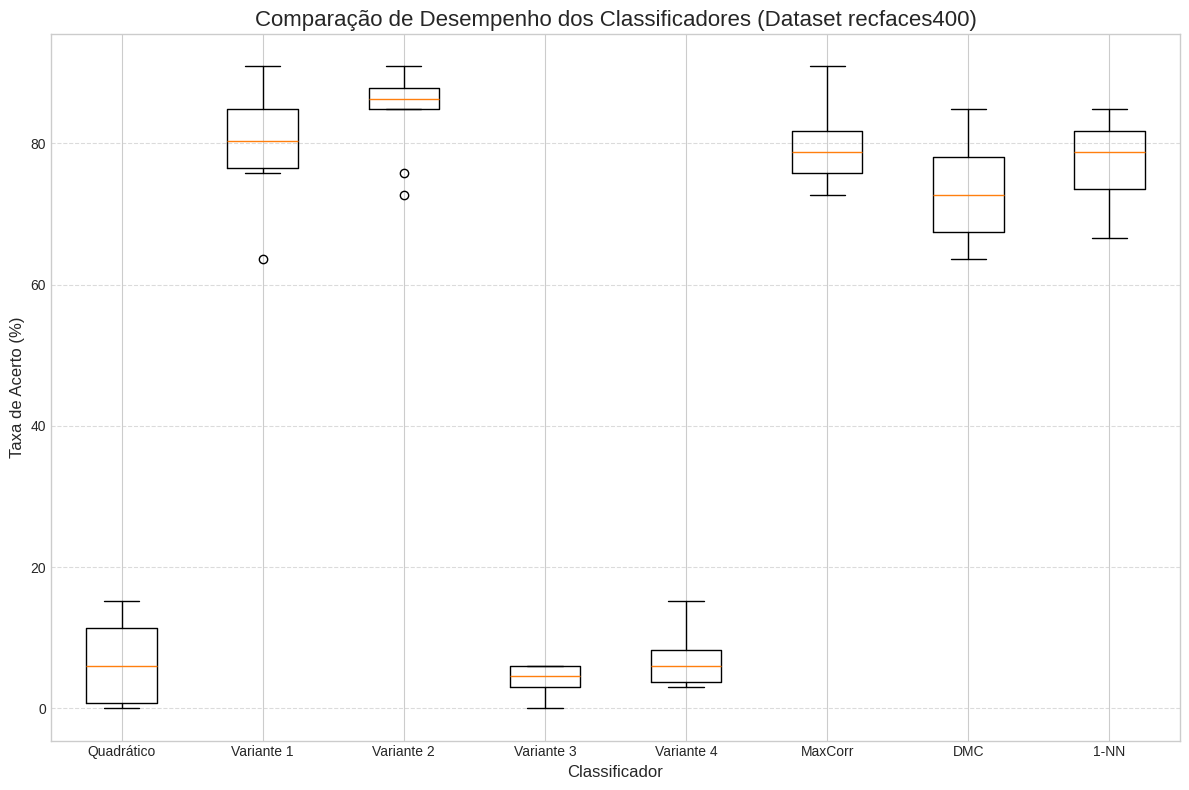

In [69]:
# --- Carregamento dos dados ---
try:
    D = np.loadtxt('recfaces400.dat')
except FileNotFoundError:
    print("Erro: Arquivo 'recfaces400.dat' não encontrado.")
    exit(1)


# --- Parâmetros ---
Nr = 10      # Número de rodadas
Ptrain = 80  # Percentual de treino

print("Executando os classificadores na ordem especificada...")

# --- Execução e medição de tempo (seguindo o modelo) ---

# 1. Quadrático
start_time = time.time()
STATS_0, TX_OK_0, _, _, _, _ = quadratico(D, Nr, Ptrain)
Tempo_0 = time.time() - start_time
print("Finalizado: Quadrático")

# 2. Variante 1 Regularization method 1 (Tikhonov)
start_time = time.time()
STATS_1, TX_OK_1, _, _, _, _ = variante1(D, Nr, Ptrain, 0.01)
Tempo_1 = time.time() - start_time
print("Finalizado: Variante 1")

# 3. Variante 2 One common COV matrix (pooled)
start_time = time.time()
STATS_2, TX_OK_2, _, _, _, _ = variante2(D, Nr, Ptrain)
Tempo_2 = time.time() - start_time
print("Finalizado: Variante 2")

# 4. Variante 3 Regularization method 2 (Friedman)
start_time = time.time()
STATS_3, TX_OK_3, _, _, _, _ = variante3(D, Nr, Ptrain, 0.5)
Tempo_3 = time.time() - start_time
print("Finalizado: Variante 3")

# 5. Variante 4 % Naive Bayes Local (Based on quadratico)
start_time = time.time()
STATS_4, TX_OK_4, _, _, _, _ = variante4(D, Nr, Ptrain)
Tempo_4 = time.time() - start_time
print("Finalizado: Variante 4")

# 6. Máxima Correlação (MaxCorr)
start_time = time.time()
STATS_MaxCorr, TX_OK_MaxCorr, _, _ = MaxCorr(D, Nr, Ptrain)
Tempo_MaxCorr = time.time() - start_time
print("Finalizado: MaxCorr")

# 7. Distância Mínima do Centroide (DMC)
start_time = time.time()
STATS_DMC, TX_OK_DMC, _, _ = DMC(D, Nr, Ptrain)
Tempo_DMC = time.time() - start_time
print("Finalizado: DMC")

# 8. 1-Vizinho Mais Próximo (1-NN)
start_time = time.time()
STATS_1NN, TX_OK_1NN, _, _ = NN1(D, Nr, Ptrain)
Tempo_1NN = time.time() - start_time
print("Finalizado: 1-NN")

print("\nExecução de todos os classificadores finalizada.")


# --- Agrupamento dos resultados para exibição ---
# A ordem aqui deve corresponder à ordem de execução
classifier_names = [
    'Quadrático',
    'Variante 1',
    'Variante 2',
    'Variante 3',
    'Variante 4',
    'MaxCorr',
    'DMC',
    '1-NN'
]

all_stats = [
    STATS_0,
    STATS_1,
    STATS_2,
    STATS_3,
    STATS_4,
    STATS_MaxCorr,
    STATS_DMC,
    STATS_1NN
]

all_times = [
    Tempo_0,
    Tempo_1,
    Tempo_2,
    Tempo_3,
    Tempo_4,
    Tempo_MaxCorr,
    Tempo_DMC,
    Tempo_1NN
]

all_tx_ok = [
    TX_OK_0,
    TX_OK_1,
    TX_OK_2,
    TX_OK_3,
    TX_OK_4,
    TX_OK_MaxCorr,
    TX_OK_DMC,
    TX_OK_1NN
]

# --- Montagem e exibição do DataFrame ---
stats_array = np.array(all_stats)
data_for_df = {
    'Média': stats_array[:, 0],
    'Mínimo': stats_array[:, 1],
    'Máximo': stats_array[:, 2],
    'Mediana': stats_array[:, 3],
    'Desvio Padrão': stats_array[:, 4],
    'Tempo de execução (s)': all_times
}

df_results = pd.DataFrame(data_for_df, index=classifier_names)
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- TABELA DE RESULTADOS (ORDEM ESPECIFICADA) ---")
display(df_results)


# --- Plotagem do Boxplot ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
plt.boxplot(all_tx_ok, patch_artist=False, labels=classifier_names) # patch_artist=False para estilo mais limpo
plt.title('Comparação de Desempenho dos Classificadores (Dataset recfaces400)', fontsize=16)
plt.xlabel('Classificador', fontsize=12)
plt.ylabel('Taxa de Acerto (%)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# --- Carregamento dos dados ---
try:
    D = np.loadtxt('recfaces900.dat')
except FileNotFoundError:
    print("Erro: Arquivo 'recfaces900.dat' não encontrado.")
    exit(1)


# --- Parâmetros ---
Nr = 50      # Número de rodadas
Ptrain = 80  # Percentual de treino

print("Executando os classificadores na ordem especificada...")

# --- Execução e medição de tempo (seguindo o modelo) ---

# 1. Quadrático
start_time = time.time()
STATS_0, TX_OK_0, _, _, _, _ = quadratico(D, Nr, Ptrain)
Tempo_0 = time.time() - start_time
print("Finalizado: Quadrático")

# 2. Variante 1 Regularization method 1 (Tikhonov)
start_time = time.time()
STATS_1, TX_OK_1, _, _, _, _ = variante1(D, Nr, Ptrain, 0.01)
Tempo_1 = time.time() - start_time
print("Finalizado: Variante 1")

# 3. Variante 2 One common COV matrix (pooled)
start_time = time.time()
STATS_2, TX_OK_2, _, _, _, _ = variante2(D, Nr, Ptrain)
Tempo_2 = time.time() - start_time
print("Finalizado: Variante 2")

# 4. Variante 3 Regularization method 2 (Friedman)
start_time = time.time()
STATS_3, TX_OK_3, _, _, _, _ = variante3(D, Nr, Ptrain, 0.5)
Tempo_3 = time.time() - start_time
print("Finalizado: Variante 3")

# 5. Variante 4 % Naive Bayes Local (Based on quadratico)
start_time = time.time()
STATS_4, TX_OK_4, _, _, _, _ = variante4(D, Nr, Ptrain)
Tempo_4 = time.time() - start_time
print("Finalizado: Variante 4")

# 6. Máxima Correlação (MaxCorr)
start_time = time.time()
STATS_MaxCorr, TX_OK_MaxCorr, _, _ = MaxCorr(D, Nr, Ptrain)
Tempo_MaxCorr = time.time() - start_time
print("Finalizado: MaxCorr")

# 7. Distância Mínima do Centroide (DMC)
start_time = time.time()
STATS_DMC, TX_OK_DMC, _, _ = DMC(D, Nr, Ptrain)
Tempo_DMC = time.time() - start_time
print("Finalizado: DMC")

# 8. 1-Vizinho Mais Próximo (1-NN)
start_time = time.time()
STATS_1NN, TX_OK_1NN, _, _ = NN1(D, Nr, Ptrain)
Tempo_1NN = time.time() - start_time
print("Finalizado: 1-NN")

print("\nExecução de todos os classificadores finalizada.")


# --- Agrupamento dos resultados para exibição ---
# A ordem aqui deve corresponder à ordem de execução
classifier_names = [
    'Quadrático',
    'Variante 1',
    'Variante 2',
    'Variante 3',
    'Variante 4',
    'MaxCorr',
    'DMC',
    '1-NN'
]

all_stats = [
    STATS_0,
    STATS_1,
    STATS_2,
    STATS_3,
    STATS_4,
    STATS_MaxCorr,
    STATS_DMC,
    STATS_1NN
]

all_times = [
    Tempo_0,
    Tempo_1,
    Tempo_2,
    Tempo_3,
    Tempo_4,
    Tempo_MaxCorr,
    Tempo_DMC,
    Tempo_1NN
]

all_tx_ok = [
    TX_OK_0,
    TX_OK_1,
    TX_OK_2,
    TX_OK_3,
    TX_OK_4,
    TX_OK_MaxCorr,
    TX_OK_DMC,
    TX_OK_1NN
]

# --- Montagem e exibição do DataFrame ---
stats_array = np.array(all_stats)
data_for_df = {
    'Média': stats_array[:, 0],
    'Mínimo': stats_array[:, 1],
    'Máximo': stats_array[:, 2],
    'Mediana': stats_array[:, 3],
    'Desvio Padrão': stats_array[:, 4],
    'Tempo de execução (s)': all_times
}

df_results = pd.DataFrame(data_for_df, index=classifier_names)
pd.options.display.float_format = '{:,.2f}'.format

print("\n--- TABELA DE RESULTADOS (ORDEM ESPECIFICADA) ---")
display(df_results)


# --- Plotagem do Boxplot ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
plt.boxplot(all_tx_ok, patch_artist=False, labels=classifier_names) # patch_artist=False para estilo mais limpo
plt.title('Comparação de Desempenho dos Classificadores (Dataset recfaces400)', fontsize=16)
plt.xlabel('Classificador', fontsize=12)
plt.ylabel('Taxa de Acerto (%)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()